In [5]:
import os
import nltk
import json
import pickle
from collections import Counter 
from pycocotools.coco import COCO

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [36]:
import torch
import numpy as np
import torch.nn as nn
import torch.utils.data as data

import torchvision.models as models
import torchvision.transforms as transforms

# Processing Captions

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Building bag of words

Function for counting number of words in COCO annotation

In [17]:
def build_tokens_counter(json_path):
    coco = COCO(json_path)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id_ in enumerate(ids):
        caption = str(coco.anns[id_]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)
        if (i+1)%10000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))
    return counter

In [18]:
tokens_counter = build_tokens_counter('data/annotations/captions_train2014.json')

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
[10000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[30000/414113] Tokenized the captions.
[40000/414113] Tokenized the captions.
[50000/414113] Tokenized the captions.
[60000/414113] Tokenized the captions.
[70000/414113] Tokenized the captions.
[80000/414113] Tokenized the captions.
[90000/414113] Tokenized the captions.
[100000/414113] Tokenized the captions.
[110000/414113] Tokenized the captions.
[120000/414113] Tokenized the captions.
[130000/414113] Tokenized the captions.
[140000/414113] Tokenized the captions.
[150000/414113] Tokenized the captions.
[160000/414113] Tokenized the captions.
[170000/414113] Tokenized the captions.
[180000/414113] Tokenized the captions.
[190000/414113] Tokenized the captions.
[200000/414113] Tokenized the captions.
[210000/414113] Tokenized the captions.
[220000/414113] Tokenized the captions.
[230000/414113] Tokenized the captions.
[24000

## Wrapper object for assigning id to token

In [25]:
class TokenIndex:
    def __init__(self):
        self.token2Idx = {}
        self.idx2Token = {}
        self.current_idx = 0

    def __call__(self, token):
        if token in self.token2Idx:
            return self.token2Idx[token]
        else:
            return self.token2Idx['<unk>']
            
    def __len__(self):
        return len(self.token2Idx)
    
    def add_token(self, token):
        if not token in self.token2Idx:
            self.token2Idx[token] = self.current_idx
            self.idx2Token[self.current_idx] = token
            self.current_idx += 1

In [26]:
def build_tokenIndex(tokens_counter, threshold):
    kept_tokens = [t for t,c in tokens_counter.items() if c>=threshold]
    tokenIndex = TokenIndex()
    
    tokenIndex.add_token('<pad>')
    tokenIndex.add_token('<unk>')
    tokenIndex.add_token('<start>')
    tokenIndex.add_token('<end>')

    for t in kept_tokens:
        tokenIndex.add_token(t)

    return tokenIndex

In [31]:
token_index = build_tokenIndex(tokens_counter, 5)

In [32]:
token_index('hello')

6499

In [33]:
# for training reuse
with open('token_counter.pkl', 'wb') as file:
    pickle.dump(tokens_counter, file)

with open('token_index.pkl', 'wb') as file:
    pickle.dump(token_index, file)

# Preprocess Images

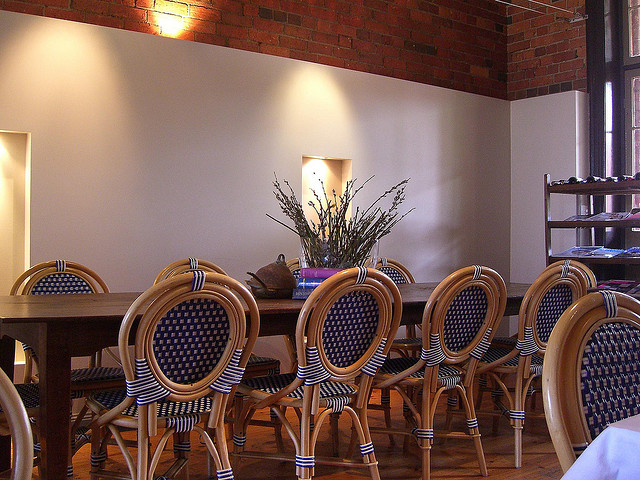

In [8]:
# show one photo
img_path = os.path.join("data/train2014", "COCO_train2014_000000057870.jpg")
img = Image.open(img_path)
img

In [11]:
#convert to numpy array
img_arr = np.array(img)
img_arr.shape

(480, 640, 3)

## Function for resizing the image

In [12]:
def reshape_image(image, shape_tuple):
    return image.resize(shape_tuple, Image.LANCZOS)

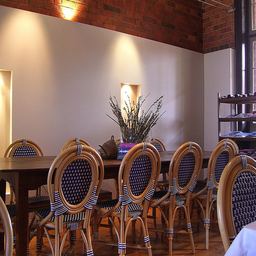

In [22]:
img_reshaped = reshape_image(img, (256, 256))
img_reshaped

In [19]:
def reshape_images_from_folder(folder_path, output_path, shape_tuple):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_paths = os.listdir(folder_path)
    for i, img_path in enumerate(image_paths):
        with open(os.path.join(folder_path, img_path), 'rb') as file:
            with Image.open(file) as img:
                img_reshaped = reshape_image(img, shape_tuple)
                img_reshaped.save(os.path.join(output_path, img_path), img_reshaped.format)
        if (i+1) % 2000 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'.".format(i+1, len(image_paths), output_path))

In [20]:
reshape_images_from_folder("data/train2014", "data/reshaped_train2014", (256, 256))

[2000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[4000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[6000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[8000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[10000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[12000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[14000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[16000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[18000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[20000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[22000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[24000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[26000/82783] Resized the images and saved into 'data/reshaped_train2014'.
[28000/82783] Resized the ima

# DataLoader for Model fetching data in batch

In [37]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, image_path, coco_json_path, token2Index, transform_pl=None):
        """
        Args:
            image_path: image directory
            coco_json_path: coco annotation file path.
            tokenIndex: tokenIndex object
            transform_pl: pytorch transformation pipeline for image
        """
        self.image_root_dir = image_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.token2Index = token2Index
        self.transform_pl = transform_pl

    def __getitem__(self, idx):
        """return data in pair (image & caption)"""
        anno_id = self.indices[idx]
        caption = self.coco_data.anns[anno_id]['caption']
        img_id = self.coco_data.anns[anno_id]['image_id']
        img_nme = self.coco_data.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.image_root_dir, img_nme)).convert('RGB')
        if self.transform_pl is not None:
            img = self.transform_pl(img)

        # Convert caption (string) to word ids
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.token2Index('<start>'))
        caption.extend([self.token2Index(token) for token in word_tokens])
        caption.append(self.token2Index('<end>'))
        ground_truth = torch.Tensor(caption)
        return img, ground_truth

    def __len__(self):
        return len(self.indices)

In [38]:
coco_dataset = CustomCocoDataset("data/reshaped_train2014", "data/annotations/captions_train2014.json", token_index)

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


In [39]:
len(coco_dataset)

414113

In [46]:
img, caption_t = coco_dataset[0]

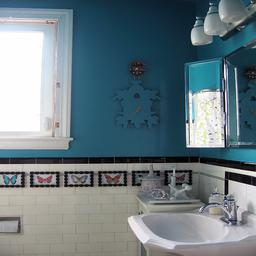

In [47]:
img

In [48]:
caption_t

tensor([ 2.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,  3.])